In [108]:
import time
import importlib
from typing import Union
from typing_extensions import TypedDict

from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

import numpy as np
import pandas as pd
from sklearn import linear_model as sk_linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.pipeline import Pipeline
import torch 
import library.functions.misc_helper_functions as misc_helpers
import library.data.data_helper_functions as data_helpers
from library.base_models import tree_models, linear_models
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import mapie
from sklearn.utils import parallel_backend

from IPython.display import display, display_latex
plt.rc('axes', axisbelow=True)
import matplotlib.colors as colors


In [19]:
class ARGS(object):
    def __init__(self):
        self.batch_size = 1
        self.data_type = torch.float
        self.validation_fraction = 0.3
        self.seed = 10
        self.device = torch.device('cpu')
        self.data_folder = '/work1/s174505/Thesis/Data/'
        self.training_data_file = 'Real_data_training.pt'
        self.debugging = False
        self.use_cv = False
args = ARGS()

train_dataset, val_dataset = data_helpers.load_data_training(args)

params = {'batch_size': args.batch_size,
        'shuffle': False,
        'drop_last': False}
train_loader = torch.utils.data.DataLoader(train_dataset, **params)
val_loader = torch.utils.data.DataLoader(val_dataset, **params)

train_X = [X[0] for X,_ in train_loader]
train_y = [y[0] for _,y in train_loader]
val_X = [X[0] for X,_ in val_loader]
val_y = [y[0] for _,y in val_loader]


Atrain = torch.cat(train_X,axis=1).permute(1,0).numpy()
ytrain = torch.cat(train_y,axis=1).permute(1,0).numpy()
Aval = torch.cat(val_X,axis=1).permute(1,0).numpy()
yval = torch.cat(val_y,axis=1).permute(1,0).numpy()

Ascaler = StandardScaler()
Ascaler.fit(Atrain)
Atrain_trans = Ascaler.transform(Atrain)
Aval_trans = Ascaler.transform(Aval)

yscaler = StandardScaler()
yscaler.fit(ytrain)
ytrain_trans = yscaler.transform(ytrain)
yval_trans = yscaler.transform(yval)

def report_me(error, train: bool):
    if train:
        print('Train ME')
    else:
        print('Validation ME')
    print(np.abs(error).mean(0), np.abs(error).mean(),sep='\n\t')
    print(np.quantile(np.abs(error),0.95,axis=0), np.quantile(np.abs(error),0.95),sep='\n\t')
    print(np.abs(error).max(0), np.abs(error).max(),sep='\n\t')

    return (np.abs(error).mean(0), np.quantile(np.abs(error),0.95,axis=0),np.abs(error).max(0), 
            np.abs(error).mean(), np.quantile(np.abs(error),0.95),np.abs(error).max())

## PCA

Quantiles: 19 25 30


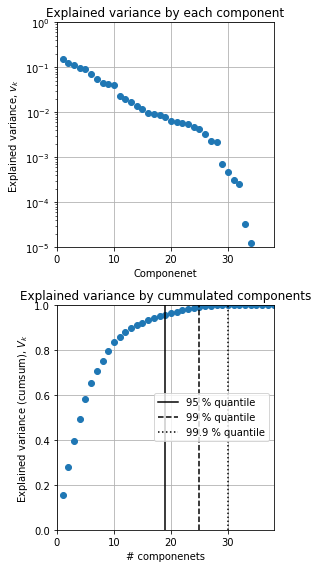

In [20]:
pca = decomposition.PCA()
pca.fit(Atrain)

explained_var = np.array(pca.explained_variance_ratio_)

fig, axes = plt.subplots(2,1,figsize=(4, 8))
ax = axes[0]
ax.scatter(np.arange(1, len(explained_var)+1), explained_var)
ax.set_xlabel('Componenet')
ax.set_ylabel('Explained variance, $v_k$')
ax.set_title('Explained variance by each component')
ax.set_ylim([1e-5, 1])
ax.set_xlim([0, 38])
ax.set_yscale('log')
ax.grid()

ax = axes[1]
ax.scatter(np.arange(1, len(explained_var)+1), explained_var.cumsum())
q95 = np.nonzero(explained_var.cumsum()>=0.95)[0][0]+1
q99 = np.nonzero(explained_var.cumsum()>=0.99)[0][0]+1
q999 = np.nonzero(explained_var.cumsum()>=0.999)[0][0]+1
ax.axvline(q95, color='k', ls='-', label='95 % quantile')
ax.axvline(q99, color='k', ls='--', label='99 % quantile')
ax.axvline(q999, color='k', ls=':', label='99.9 % quantile')
ax.set_xlabel('# componenets')
ax.set_ylabel('Explained variance (cumsum), $V_k$')
ax.set_title('Explained variance by cummulated components')
ax.set_ylim([0, 1])
ax.set_xlim([0, 38])
ax.legend(loc="right")
ax.grid()

fig.tight_layout()
print('Quantiles:', q95, q99, q999)

fig.savefig('plots/PCA explained variance.pdf', format='pdf')

In [21]:
pca_y = decomposition.PCA()
pca_y.fit(ytrain)

explained_var_y = np.array(pca_y.explained_variance_ratio_)

In [22]:
print(Atrain.shape)

(147000, 38)


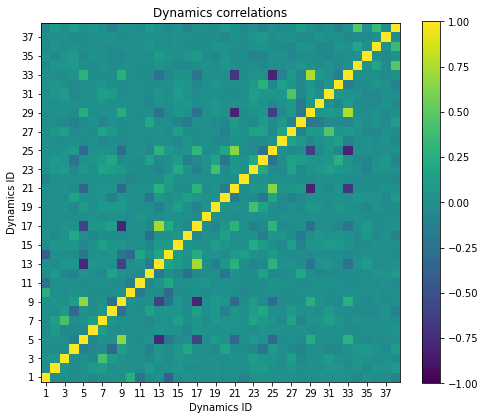

In [63]:
fig, ax = plt.subplots(figsize=(7,7))
correlation = np.corrcoef(Atrain.T)
pos = ax.imshow(np.flipud(correlation), vmin=-1, vmax=1)
ax.set_xticks([i for i in range(0,38,2)])
ax.set_xticklabels([1+i for i in range(0,38,2)])
ax.set_yticks([i for i in range(1,38,2)])
ax.set_yticklabels([38-i for i in range(1,38,2)])
fig.colorbar(pos, ax=ax, shrink=0.75)
ax.set_xlabel("Dynamics ID")
ax.set_ylabel("Dynamics ID")
ax.set_title("Dynamics correlations")
fig.tight_layout()

fig.savefig("plots/correlation A.pdf", format="pdf")

In [24]:
r = correlation[1,5]
n=len(Atrain)
t = r * np.sqrt(n-2)/np.sqrt(1-r**2)
print(t)

from scipy.stats.stats import pearsonr

pearsonr(Atrain[:,1], Atrain[:,9])

34.19003425522247


(0.006608586447784975, 0.011284070029769382)

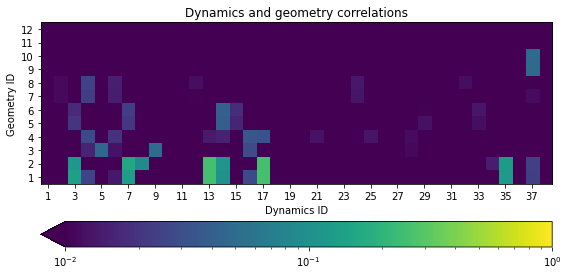

In [80]:
fig, ax = plt.subplots(figsize=(8,4))
correlation = np.corrcoef(Atrain.T, ytrain.T)[38:,:38]
pos = ax.imshow(np.flipud(correlation), norm=colors.LogNorm(vmin=1e-2, vmax=1, clip=True))
ax.set_xticks([i for i in range(0,38,2)])
ax.set_xticklabels([1+i for i in range(0,38,2)])
ax.set_yticks([i for i in range(0,12,1)])
ax.set_yticklabels([12-i for i in range(0,12,1)])
fig.colorbar(pos, ax=ax, shrink=1, orientation="horizontal", extend="min")
ax.set_xlabel("Dynamics ID")
ax.set_ylabel("Geometry ID")
ax.set_title("Dynamics and geometry correlations")
fig.tight_layout()

fig.savefig("plots/correlation Ay.pdf", format="pdf")

(array([-40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28,
        -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
        -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
         -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40]),
 array([-0.23571946, -0.23568691, -0.2356877 , -0.23539451, -0.23119907,
        -0.23556824, -0.23506436, -0.23851034, -0.23873067, -0.23485617,
        -0.23416533, -0.23403811, -0.23448317, -0.2414096 , -0.23525627,
        -0.23788159, -0.23315763, -0.23616003, -0.23253973, -0.23599085,
        -0.23697409, -0.23657456, -0.23207428, -0.23532185, -0.24069326,
        -0.23818533, -0.23607764, -0.23611183, -0.23307772, -0.23609003,
        -0.23561177, -0.2364461 , -0.23807798, -0.2334743 , -0.23040868,
        -0.23582432, -0.23

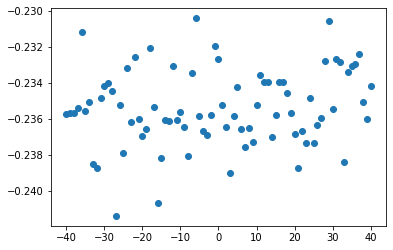

In [26]:
plt.xcorr(Atrain[:,1], Atrain[:,17], maxlags=40, usevlines=False)

## Constant models

In [27]:
train_mean = ytrain.mean(0)
err_train_mean = train_mean - ytrain
err_val_mean = train_mean - yval

constant_train = report_me(err_train_mean, train=True)
constant_val = report_me(err_val_mean, train=False)

Train ME
[0.56512874 0.5893672  0.3323355  0.3241251  0.70823234 0.74861276
 0.45993766 0.46560386 1.5619465  1.5766225  1.4488736  1.4507049 ]
	0.8526244
[1.78974247 1.85978711 0.87995857 0.85991096 2.06283259 2.14725447
 1.27048934 1.29931569 4.46131659 4.4808116  3.92779016 3.91708612]
	2.921316623687744
[ 9.290257   9.340213   5.5899587  5.689911   6.4328327  6.9527454
  5.100489   4.660684  12.931316  13.469188  14.60221   14.942913 ]
	14.942913
Validation ME
[0.526786   0.5661305  0.33304566 0.32691646 0.7142421  0.75255877
 0.44327524 0.45337152 1.6246799  1.6326784  1.5314623  1.5115854 ]
	0.86806095
[1.66025746 1.76978707 0.88004142 0.87008905 2.14283276 2.2172544
 1.23048937 1.24068427 4.83131695 4.81918812 4.35779047 4.29708624]
	3.0291879177093506
[ 7.4902573  7.7902126  2.9400415  3.029911   8.032832   7.2727456
  3.0504894  3.0806842 14.258684  13.430812   9.782209   9.752913 ]
	14.258684


## Linear model

In [28]:
reg = sk_linear_model.LinearRegression()
reg.fit(Atrain_trans, ytrain)

yhat_train = reg.predict(Atrain_trans)
yhat_val = reg.predict(Aval_trans)

err_train = yhat_train - ytrain
err_val = yhat_val - yval

linear_train = report_me(err_train, train=True)
linear_val = report_me(err_val, train=False)

Train ME
[0.51013    0.5337881  0.33123446 0.32305726 0.70254946 0.74257857
 0.458983   0.46469292 1.5571959  1.5709985  1.4477519  1.4497654 ]
	0.84106505
[1.51964161 1.59631473 0.87309661 0.85487145 2.04191986 2.12262378
 1.26682341 1.29498649 4.44135375 4.45906775 3.92417256 3.91977414]
	2.8790004014968855
[ 7.402912   7.8077745  5.5889163  5.7452283  6.3115396  6.8753247
  5.1139407  4.6068897 13.366178  13.863679  14.57482   14.934152 ]
	14.934152
Validation ME
[0.48112452 0.5175409  0.33250362 0.32597846 0.7095941  0.74667513
 0.4427423  0.45258802 1.6173155  1.6253062  1.5295784  1.5099715 ]
	0.8575764
[1.42538214 1.53634416 0.87886195 0.8646099  2.11498077 2.18698479
 1.23038084 1.23927256 4.81410618 4.80343211 4.34738181 4.30216503]
	2.9886008143424987
[ 6.4439063  5.968341   2.9622242  3.0582447  7.958668   7.181669
  3.0371447  3.0628471 14.371231  13.606842   9.892001   9.853044 ]
	14.371231


In [29]:
print(np.linalg.cond(Atrain))
print(np.linalg.cond(Atrain_trans))

3247539.5
7.0979333


In [30]:
N = 50
Ridge_train_ME = [None] * N
Ridge_val_ME = [None] * N
alphas = np.logspace(4, np.log10(50000), N)
for i, alpha in enumerate(alphas):
    reg = sk_linear_model.Ridge(alpha=alpha)
    reg.fit(Atrain_trans, ytrain)

    yhat_train = reg.predict(Atrain_trans)
    yhat_val = reg.predict(Aval_trans)

    err_train = yhat_train - ytrain
    err_val = yhat_val - yval
    
    Ridge_train_ME[i] = np.abs(err_train).mean()
    Ridge_val_ME[i] = np.abs(err_val).mean()

In [31]:
reg = sk_linear_model.Ridge(alpha=alphas[np.argmin(Ridge_val_ME)])
reg.fit(Atrain_trans, ytrain)

yhat_train = reg.predict(Atrain_trans)
yhat_val = reg.predict(Aval_trans)

err_train = yhat_train - ytrain
err_val = yhat_val - yval

ridge_train = report_me(err_train, train=True)
ridge_val = report_me(err_val, train=False)

Train ME
[0.50640684 0.52894926 0.33129656 0.32313043 0.7025018  0.7426842
 0.45898694 0.46465018 1.5561876  1.5702189  1.4477035  1.4496994 ]
	0.8402039
[1.53987934 1.61642179 0.8735433  0.8548715  2.04283868 2.1266107
 1.26764184 1.29684362 4.43782494 4.458833   3.92356713 3.91966267]
	2.883601570129394
[ 7.5413     7.8449492  5.5546083  5.7085032  6.3594785  6.8009853
  5.081898   4.61364   13.29843   13.79885   14.579403  14.938127 ]
	14.938127
Validation ME
[0.4758329  0.5108103  0.33251244 0.32599136 0.7091181  0.74653494
 0.44258803 0.45251614 1.6169803  1.6250927  1.5297301  1.5100276 ]
	0.8564796
[1.44428918 1.54818262 0.87827126 0.866177   2.11706758 2.1908594
 1.23252234 1.23802965 4.80755215 4.81147702 4.35161557 4.30438268]
	2.992372369766234
[ 6.184156   6.22925    2.9685204  3.045132   7.98498    7.2022257
  3.037142   3.0617237 14.351125  13.582962   9.851662   9.819556 ]
	14.351125


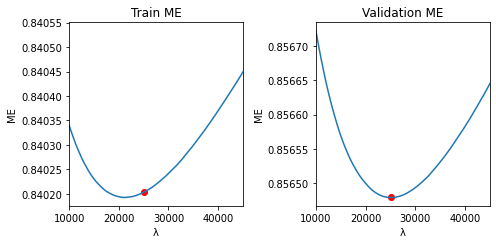

In [86]:
fig, axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].plot(alphas, Ridge_train_ME, label='Ridge')
axes[0].scatter(alphas[np.argmin(Ridge_val_ME)], Ridge_train_ME[np.argmin(Ridge_val_ME)], color='r')
axes[0].set_title('Train ME')

axes[1].plot(alphas, Ridge_val_ME)
axes[1].scatter(alphas[np.argmin(Ridge_val_ME)], Ridge_val_ME[np.argmin(Ridge_val_ME)], color='r')
axes[1].set_title('Validation ME')
for ax in axes:
    #ax.set_xscale('log')
    ax.set_xlabel("λ")
    ax.set_ylabel('ME')
    ax.set_xlim([alphas[0], 45000])
fig.tight_layout()
fig.savefig('plots/Ridge coefficient.pdf', format='pdf')

In [33]:
alphas[np.argmin(Ridge_val_ME)]

25084.845531135186

## Tree models

In [34]:
tree_ME_train = None
tree_ME_val = None
err_best = None
tree_train_ME = []
tree_val_ME = []
depths = list(range(3,14))
for depth in depths:
    regr_tree = tree.DecisionTreeRegressor(max_depth=depth)

    regr_tree.fit(Atrain, ytrain)

    yhat_train_tree = regr_tree.predict(Atrain)
    yhat_val_tree = regr_tree.predict(Aval)

    err_train_tree = yhat_train_tree - ytrain
    err_val_tree = yhat_val_tree - yval
    
    tree_train_ME.append( np.mean(np.abs(err_train_tree)) )
    tree_val_ME.append( np.mean(np.abs(err_val_tree)) )

In [35]:
regr_tree = tree.DecisionTreeRegressor(max_depth=depths[np.argmin(tree_val_ME)])

regr_tree.fit(Atrain, ytrain)

yhat_train_tree = regr_tree.predict(Atrain)
yhat_val_tree = regr_tree.predict(Aval)

err_train_tree = yhat_train_tree - ytrain
err_val_tree = yhat_val_tree - yval

tree_train = report_me(err_train_tree, train=True)
tree_val = report_me(err_val_tree, train=False)

Train ME
[0.54784443 0.57084737 0.33142714 0.32350629 0.69966224 0.74038427
 0.45690792 0.46227089 1.53651899 1.55016448 1.3222091  1.32380486]
	0.8221289996556496
[1.71988001 1.79989149 0.87422995 0.85534194 2.03358417 2.12795163
 1.25510713 1.28283921 4.37104291 4.38591819 3.64898692 3.61915239]
	2.7703950760097875
[ 7.37202325  8.49868524  5.54524864  5.69401218  6.38772603  6.81752405
  5.07768586  4.63716063 12.76899003 13.19911456 14.1317689  14.50306439]
	14.50306439418087
Validation ME
[0.51669206 0.55365624 0.33358747 0.32714307 0.71384661 0.75133281
 0.44570545 0.45624745 1.63506917 1.63888999 1.45010848 1.43199448]
	0.8545227733536986
[1.63162852 1.73388195 0.88046529 0.87001476 2.13735129 2.20182974
 1.2397089  1.24535388 4.88535172 4.86340859 4.19903353 4.1650994 ]
	2.9602918247869225
[ 6.72231487  7.00010859  2.95624468  3.16375004  8.03920407  7.28405353
  3.10489277  3.14716678 14.11738094 13.21667595 10.21125018  9.57375016]
	14.117380943712787


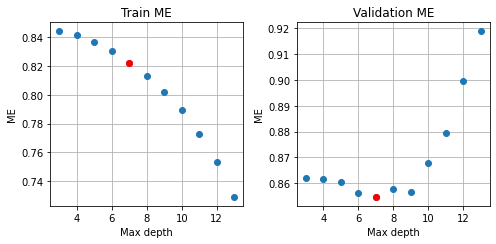

In [88]:
fig, axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(depths, tree_train_ME)
axes[0].scatter(depths[np.argmin(tree_val_ME)], tree_train_ME[np.argmin(tree_val_ME)], c='r')
axes[0].set_title('Train ME')
axes[1].scatter(depths, tree_val_ME)
axes[1].scatter(depths[np.argmin(tree_val_ME)], tree_val_ME[np.argmin(tree_val_ME)], c='r')
axes[1].set_title('Validation ME')
for ax in axes:
    ax.set_xlabel('Max depth')
    ax.set_ylabel('ME')
    ax.grid()
fig.tight_layout()
fig.savefig('plots/Regression tree depth.pdf', format='pdf')

## Ensemble

In [37]:
res_train10  = pd.read_pickle('results/random_forest/Random_forest_train_results_10.pkl') # recalculated
res_train50  = pd.read_pickle('results/random_forest/Random_forest_train_results_50.pkl'
                             )[2:].reset_index().drop(columns='index')
res_train100 = pd.read_pickle('results/random_forest/Random_forest_train_results_100.pkl'
                             )[2:].reset_index().drop(columns='index')
res_train500 = pd.read_pickle('results/random_forest/Random_forest_train_results_500.pkl'
                             )[2:].reset_index().drop(columns='index')

large_train10  = pd.read_pickle('results/random_forest/Random_forest_train_results_large_10.pkl')
large_train50  = pd.read_pickle('results/random_forest/Random_forest_train_results_large_50.pkl')
large_train100 = pd.read_pickle('results/random_forest/Random_forest_train_results_large_100.pkl')
large_train500 = pd.read_pickle('results/random_forest/Random_forest_train_results_large_500.pkl')
res_train10['# trees 10000'] = large_train10
res_train50['# trees 10000'] = large_train50
res_train100['# trees 10000'] = large_train100
res_train500['# trees 10000'] = large_train500

res_val10  = pd.read_pickle('results/random_forest/Random_forest_val_results_10.pkl') # recalculated
res_val50  = pd.read_pickle('results/random_forest/Random_forest_val_results_50.pkl'
                           )[2:].reset_index().drop(columns='index')
res_val100 = pd.read_pickle('results/random_forest/Random_forest_val_results_100.pkl'
                           )[2:].reset_index().drop(columns='index')
res_val500 = pd.read_pickle('results/random_forest/Random_forest_val_results_500.pkl'
                           )[2:].reset_index().drop(columns='index')
large_val10  = pd.read_pickle('results/random_forest/Random_forest_val_results_large_10.pkl')
large_val50  = pd.read_pickle('results/random_forest/Random_forest_val_results_large_50.pkl')
large_val100 = pd.read_pickle('results/random_forest/Random_forest_val_results_large_100.pkl')
large_val500 = pd.read_pickle('results/random_forest/Random_forest_val_results_large_500.pkl')
res_val10['# trees 10000'] = large_val10
res_val50['# trees 10000'] = large_val50
res_val100['# trees 10000'] = large_val100
res_val500['# trees 10000'] = large_val500

In [38]:

res_train_mean = pd.DataFrame({
    "Factor 10" : res_train10.mean(),
    "Factor 50" : res_train50.mean(),
    "Factor 100" : res_train100.mean(),
    "Factor 500" : res_train500.mean(),
})
display(res_train_mean)
res_val_mean = pd.DataFrame({
    "Factor 10" : res_val10.mean(),
    "Factor 50" : res_val50.mean(),
    "Factor 100" : res_val100.mean(),
    "Factor 500" : res_val500.mean(),

})
display(res_val_mean.values)

,Factor 10,Factor 50,Factor 100,Factor 500
# trees 100,0.693172,0.426738,0.249653,0.250197
# trees 500,0.782116,0.687936,0.600907,0.245626
# trees 1000,0.799996,0.742552,0.687311,0.421395
# trees 5000,0.828380,0.799437,0.781320,0.686816
# trees 10000,0.834364,0.815026,0.799212,0.742146


array([[0.84016626, 0.86919973, 0.88695857, 0.88664737],
       [0.82943215, 0.8366146 , 0.84616219, 0.88255527],
       [0.83125973, 0.83120818, 0.83590773, 0.8649157 ],
       [0.84638574, 0.83112512, 0.82881139, 0.83524201],
       [0.85139282, 0.83753522, 0.83050658, 0.82996514]])

In [39]:
res_train_mean.values.round(4)

array([[0.6932, 0.4267, 0.2497, 0.2502],
       [0.7821, 0.6879, 0.6009, 0.2456],
       [0.8   , 0.7426, 0.6873, 0.4214],
       [0.8284, 0.7994, 0.7813, 0.6868],
       [0.8344, 0.815 , 0.7992, 0.7421]])

In [40]:
res_val_mean.values.round(4)

array([[0.8402, 0.8692, 0.887 , 0.8866],
       [0.8294, 0.8366, 0.8462, 0.8826],
       [0.8313, 0.8312, 0.8359, 0.8649],
       [0.8464, 0.8311, 0.8288, 0.8352],
       [0.8514, 0.8375, 0.8305, 0.83  ]])

In [41]:
rf_errors_train = []
rf_errors_val = []
for k in range(ytrain.shape[1]):
    rf_errors_train.append(np.load(f'results/random_forest/rf_best_train_{k}.npy'))
    rf_errors_val.append(np.load(f'results/random_forest/rf_best_val_{k}.npy'))

In [42]:
rf_err_train = np.vstack(rf_errors_train).T
rf_err_val = np.vstack(rf_errors_val).T

rf_train=report_me(rf_err_train, train=True)
rf_val=report_me(rf_err_val, train=False)

Train ME
[0.48240281 0.50204698 0.32400515 0.31608135 0.67025936 0.70881232
 0.44860859 0.45418161 1.5173205  1.53213199 1.20763397 1.20912478]
	0.7810507841622779
[1.46865091 1.53636692 0.85348873 0.83577268 1.9497005  2.03971993
 1.23765068 1.26701328 4.33207322 4.34785978 3.36371238 3.35720791]
	2.6390240620897147
[ 6.77016178  7.87672959  5.38048615  5.58467606  6.19355819  6.63961191
  4.94334615  4.59537392 13.18443189 13.72922181 13.98996037 14.21182159]
	14.211821587063744
Validation ME
[0.4611583  0.49416746 0.33202521 0.32543791 0.69581327 0.73052937
 0.44252486 0.45207474 1.61125975 1.61964396 1.39657066 1.37807835]
	0.8282736541682659
[1.39131611 1.49780552 0.87752012 0.8628275  2.06540405 2.11916407
 1.22959051 1.23783965 4.82227112 4.79780037 4.07277838 4.0576428 ]
	2.862296192550566
[ 5.96504606  6.0107519   2.97363206  3.04617803  8.04370823  7.20611977
  3.04274996  3.08676594 14.92459245 13.89271408  9.24021011  9.29129785]
	14.924592453479022


## Adaboost

In [43]:
adaboosts = [None] * ytrain.shape[1]
t = time.time()
with parallel_backend('loky', n_jobs=-3):
    for k in range(ytrain.shape[1]):
        break
        adaboost = ensemble.AdaBoostRegressor(
            base_estimator=tree.DecisionTreeRegressor(max_depth=10),
            learning_rate=0.1, 
            loss='square')
        adaboost.fit(Atrain, ytrain[:,k])

        yhat_train_adaboost = adaboost.predict(Atrain)
        yhat_val_adaboost = adaboost.predict(Aval)

        err_train_adaboost = yhat_train_adaboost - ytrain[:,k]
        err_val_adaboost = yhat_val_adaboost - yval[:,k]

        print(f'adaboost {k}')
        print('Train ME')
        print('\t',np.mean(np.abs(err_train_adaboost)))
        print('Validation ME')
        print('\t',np.mean(np.abs(err_val_adaboost)))
        adaboosts[k] = adaboost
        print(time.time() - t)

In [44]:
t = time.time()
with parallel_backend('loky', n_jobs=-3):
    # k = 0
    for lr in [0.01, 0.1, 1]:
        for depth in [5, 8, 10]:
            break
            adaboost = ensemble.AdaBoostRegressor(
                base_estimator=tree.DecisionTreeRegressor(max_depth=depth),
                learning_rate=lr, 
                loss='square')
            adaboost.fit(Atrain, ytrain[:,k])

            yhat_train_adaboost = adaboost.predict(Atrain)
            yhat_val_adaboost = adaboost.predict(Aval)

            err_train_adaboost = yhat_train_adaboost - ytrain[:,k]
            err_val_adaboost = yhat_val_adaboost - yval[:,k]

            print(f'adaboost {lr} {depth}')
            print('Train ME')
            print('\t',np.mean(np.abs(err_train_adaboost)))
            print('Validation ME')
            print('\t',np.mean(np.abs(err_val_adaboost)))
            print(time.time() - t)

In [45]:
if adaboosts[0] != None:
    adaboost_val_ME = np.zeros(len(adaboosts))
    adaboost_errors_train = []
    adaboost_errors_val = []
    for k,a in enumerate(adaboosts):
        err_train = a.predict(Atrain) - ytrain[:,k]
        err_val = a.predict(Aval) - yval[:,k]
        adaboost_errors_train.append(err_train)
        adaboost_errors_val.append(err_val)
        # adaboost_val_ME[k] = np.mean(np.abs(err_val))

    adaboost_err_train = np.vstack(adaboost_errors_train).T
    adaboost_err_val = np.vstack(adaboost_errors_val).T
    

    np.save("cache/adaboost_err_train.npy", adaboost_err_train)
    np.save("cache/adaboost_err_val.npy", adaboost_err_val)

In [46]:
adaboost_err_train = np.load("cache/adaboost_err_train.npy")
adaboost_err_val = np.load("cache/adaboost_err_val.npy")
adaboost_feature_importances = np.load("cache/adaboost_feature_importances.npy")

In [47]:
adaboost_train=report_me(adaboost_err_train, train=True)
adaboost_val=report_me(adaboost_err_val, train=False)
adaboost_val_ME=adaboost_val[0]

Train ME
[0.46826862 0.4856339  0.33014106 0.32268099 0.67944076 0.71952255
 0.45651085 0.46061713 1.50400016 1.51834561 1.13365451 1.13923831]
	0.7681712042747144
[1.38623454 1.4468243  0.87042806 0.85857607 1.95802947 2.05494222
 1.25869538 1.28062003 4.25470692 4.27484426 3.16489772 3.19159158]
	2.583433453307611
[4.19139896 4.70095395 3.21815743 3.88509996 5.09150596 5.9293535
 3.95831195 3.68904585 9.63678707 9.38914128 8.13298216 7.826772  ]
	9.636787070927376
Validation ME
[0.46579756 0.4973371  0.33270585 0.326605   0.70212722 0.73695816
 0.4431863  0.45353452 1.62093721 1.62936418 1.44603178 1.43963768]
	0.8411852151017539
[1.39885735 1.49577775 0.88018405 0.86947915 2.08398551 2.13967253
 1.2322194  1.24186575 4.8388749  4.83959737 4.16761736 4.15711468]
	2.928569210761864
[ 5.95000005  6.60965537  2.93971779  3.02906048  7.98515257  7.24337817
  3.04741487  3.10111674 14.85436519 13.88165323  9.39993417  9.31915215]
	14.85436518941193


In [48]:
if adaboosts[0] != None:
    adaboost_feature_importances = ((
            np.array([a.feature_importances_ for a in adaboosts]).T * adaboost_val[0]
        ).sum(1)/adaboost_val[0].sum()).T
    np.save("cache/adaboost_feature_importances.npy", adaboost_feature_importances)

## Feature importance

In [49]:
print(adaboost_feature_importances)


[0.25894116 0.01191461 0.01594508 0.01069868 0.03570813 0.00990788
 0.02037954 0.01062459 0.04086355 0.01241176 0.0053104  0.00900375
 0.01631851 0.02628226 0.01580832 0.01054783 0.01908906 0.00203366
 0.009159   0.00810124 0.01875478 0.00262776 0.0110097  0.01127626
 0.01774725 0.00660484 0.00652225 0.00712038 0.01393372 0.00827433
 0.00760133 0.00719248 0.0124181  0.0111204  0.03237879 0.00950769
 0.02244977 0.24441116]


## Gradient boosted trees

In [50]:
# adaboost_ME_train, adaboost_ME_val = [], []
# random_forest_ME_train, random_forest_ME_val = [], []
gradboost_ME_train, gradboost_ME_val = [], []
gradboost_errors_train = []
gradboost_errors_val = []

for k in range(ytrain.shape[1]):
    print('Attribute:', k)

    gradboost = ensemble.HistGradientBoostingRegressor(loss='squared_error')

    gradboost.fit(Atrain, ytrain[:, k])

    yhat_train_gradboost = gradboost.predict(Atrain)
    yhat_val_gradboost = gradboost.predict(Aval)

    err_train_gradboost = yhat_train_gradboost - ytrain[:,k]
    err_val_gradboost = yhat_val_gradboost - yval[:,k]
    gradboost_errors_train.append(err_train_gradboost)
    gradboost_errors_val.append(err_val_gradboost)

Attribute: 0
Attribute: 1
Attribute: 2
Attribute: 3
Attribute: 4
Attribute: 5
Attribute: 6
Attribute: 7
Attribute: 8
Attribute: 9
Attribute: 10
Attribute: 11


In [51]:
gradboost_err_train = np.vstack(gradboost_errors_train).T
gradboost_err_val = np.vstack(gradboost_errors_val).T

gradboost_train=report_me(gradboost_err_train, train=True)
gradboost_val=report_me(gradboost_err_val, train=False)

Train ME
[0.4636775  0.48299006 0.32633968 0.31769158 0.66105445 0.69939207
 0.44406431 0.44993857 1.44441976 1.45914382 1.12008914 1.12334733]
	0.7493456894546278
[1.36833954 1.43422574 0.85832751 0.8364746  1.89425579 1.98946368
 1.21159974 1.24131546 4.06947462 4.0910867  3.05886556 3.0952365 ]
	2.4922921251139156
[ 6.7182249   6.93872871  4.50613579  4.66081304  5.95624874  6.64308637
  4.27063265  3.95939781 12.87352653 13.52049132 13.5446187  14.24997416]
	14.249974163876132
Validation ME
[0.45197564 0.48431192 0.33197415 0.32543798 0.69503116 0.73022035
 0.44390015 0.45281914 1.63552144 1.64699534 1.42569327 1.41459363]
	0.8365395149540237
[1.34686947 1.44590473 0.8759351  0.86221456 2.05732953 2.10871319
 1.22898506 1.23886703 4.8924182  4.90202282 4.10051297 4.14952928]
	2.9195187373953653
[ 5.72006592  5.85509815  3.0984661   3.13091651  8.07848449  7.37762287
  3.09859111  3.13232475 16.30026851 14.67713064 10.24397695 10.76272759]
	16.30026850584011


## Summaries results

In [52]:
train_stats = {
    'Constant' : constant_train,
    'Linear' : linear_train,
    'Ridge' : ridge_train,
    'Tree' : tree_train,
    'RF' : rf_train,
    'Adaboost' : adaboost_train,
    'Gradboost' : gradboost_train,
}
val_stats = {
    'Constant' : constant_val,
    'Linear' : linear_val,
    'Ridge' : ridge_val,
    'Tree' : tree_val,
    'RF' : rf_val,
    'Adaboost' : adaboost_val,
    'Gradboost' : gradboost_val,
}

In [53]:
df_train_simple_current_mean = pd.DataFrame({
    'Constant' : constant_train[0],
    'Linear' : linear_train[0],
    'Ridge' : ridge_train[0],
    'Tree' : tree_train[0],
    'RF' : rf_train[0],
    'Adaboost' : adaboost_train[0],
    'Gradboost' : gradboost_train[0],
}, index=[
    'LivLongSxD1 [mm]', 'LivLongDxD1 [mm]', 'AllinSxD1 [mm]', 'AllinDxD1 [mm]', 
    'LivLongSxD2 [mm]', 'LivLongDxD2 [mm]', 'AllinSxD2 [mm]', 'AllinDxD2 [mm]', 
    'LivLongSxD3 [mm]', 'LivLongDxD3 [mm]', 'AllinSxD3 [mm]', 'AllinDxD3 [mm]'])
df_train_simple_current_q95 = pd.DataFrame({
    'Constant' : constant_train[1],
    'Linear' : linear_train[1],
    'Ridge' : ridge_train[1],
    'Tree' : tree_train[1],
    'RF' : rf_train[1],
    'Adaboost' : adaboost_train[1],
    'Gradboost' : gradboost_train[1],
}, index=[
    'LivLongSxD1 [mm]', 'LivLongDxD1 [mm]', 'AllinSxD1 [mm]', 'AllinDxD1 [mm]', 
    'LivLongSxD2 [mm]', 'LivLongDxD2 [mm]', 'AllinSxD2 [mm]', 'AllinDxD2 [mm]', 
    'LivLongSxD3 [mm]', 'LivLongDxD3 [mm]', 'AllinSxD3 [mm]', 'AllinDxD3 [mm]'])
df_train_simple_current_max = pd.DataFrame({
    'Constant' : constant_train[2],
    'Linear' : linear_train[2],
    'Ridge' : ridge_train[2],
    'Tree' : tree_train[2],
    'RF' : rf_train[2],
    'Adaboost' : adaboost_train[2],
    'Gradboost' : gradboost_train[2],
}, index=['LivLongSxD1 [mm]', 'LivLongDxD1 [mm]', 'AllinSxD1 [mm]', 'AllinDxD1 [mm]', 
          'LivLongSxD2 [mm]', 'LivLongDxD2 [mm]', 'AllinSxD2 [mm]', 'AllinDxD2 [mm]', 
          'LivLongSxD3 [mm]', 'LivLongDxD3 [mm]', 'AllinSxD3 [mm]', 'AllinDxD3 [mm]'])

df_val_simple_current_mean = pd.DataFrame({
    'Constant' : constant_val[0],
    'Linear' : linear_val[0],
    'Ridge' : ridge_val[0],
    'Tree' : tree_val[0],
    'RF' : rf_val[0],
    'Adaboost' : adaboost_val[0],
    'Gradboost' : gradboost_val[0],
}, index=[
    'LivLongSxD1 [mm]', 'LivLongDxD1 [mm]', 'AllinSxD1 [mm]', 'AllinDxD1 [mm]', 
    'LivLongSxD2 [mm]', 'LivLongDxD2 [mm]', 'AllinSxD2 [mm]', 'AllinDxD2 [mm]', 
    'LivLongSxD3 [mm]', 'LivLongDxD3 [mm]', 'AllinSxD3 [mm]', 'AllinDxD3 [mm]'])
df_val_simple_current_q95 = pd.DataFrame({
    'Constant' : constant_val[1],
    'Linear' : linear_val[1],
    'Ridge' : ridge_val[1],
    'Tree' : tree_val[1],
    'RF' : rf_val[1],
    'Adaboost' : adaboost_val[1],
    'Gradboost' : gradboost_val[1],
}, index=[
    'LivLongSxD1 [mm]', 'LivLongDxD1 [mm]', 'AllinSxD1 [mm]', 'AllinDxD1 [mm]', 
    'LivLongSxD2 [mm]', 'LivLongDxD2 [mm]', 'AllinSxD2 [mm]', 'AllinDxD2 [mm]', 
    'LivLongSxD3 [mm]', 'LivLongDxD3 [mm]', 'AllinSxD3 [mm]', 'AllinDxD3 [mm]'])
df_val_simple_current_max = pd.DataFrame({
    'Constant' : constant_val[2],
    'Linear' : linear_val[2],
    'Ridge' : ridge_val[2],
    'Tree' : tree_val[2],
    'RF' : rf_val[2],
    'Adaboost' : adaboost_val[2],
    'Gradboost' : gradboost_val[2],
}, index=['LivLongSxD1 [mm]', 'LivLongDxD1 [mm]', 'AllinSxD1 [mm]', 'AllinDxD1 [mm]', 
          'LivLongSxD2 [mm]', 'LivLongDxD2 [mm]', 'AllinSxD2 [mm]', 'AllinDxD2 [mm]', 
          'LivLongSxD3 [mm]', 'LivLongDxD3 [mm]', 'AllinSxD3 [mm]', 'AllinDxD3 [mm]'])

#display(df_val_simple_current_mean[["Constant", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"]])
#print(constant_val[3], rf_val[3], gradboost_val[3])

#display(df_val_simple_current_q95[["Constant", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"]])
#print(constant_val[4], rf_val[4], gradboost_val[4])

#display(df_val_simple_current_max[["Constant", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"]])
#print(constant_val[5], rf_val[5], gradboost_val[5])

#display(pd.DataFrame(np.hstack((
#    df_val_simple_current_mean[["Constant", "RF", "Gradboost"]].values,
#    df_val_simple_current_q95[["Constant", "RF", "Gradboost"]].values,
#    df_val_simple_current_max[["Constant", "RF", "Gradboost"]].values,
#))))
df_train_simple_current_mean.to_csv('results/simple_models/df_train_simple_current_mean.csv')
df_train_simple_current_q95.to_csv('results/simple_models/df_train_simple_current_q95.csv')
df_train_simple_current_max.to_csv('results/simple_models/df_train_simple_current_max.csv')
df_val_simple_current_mean.to_csv('results/simple_models/df_val_simple_current_mean.csv')
df_val_simple_current_q95.to_csv('results/simple_models/df_val_simple_current_q95.csv')
df_val_simple_current_max.to_csv('results/simple_models/df_val_simple_current_max.csv')

In [54]:
def print_latex(data, statistic, models=True, train=True, cols=["Constant", "Linear", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"]):
    vals = data.loc[:,cols].values
    n_cols = len(cols)
    n_rows = len(data)
    if models:
        print("& ", " & ".join(cols), "\\\\\\hline")
    print("& \\multicolumn{", n_cols , "}{c}{", statistic, "} \\\\\\hline")
    for i,row in enumerate(data.index):
        print(row, end = " & ")
        for j in range(n_cols):
            if j < n_cols - 1:
                print("{:5.2f}".format(vals[i,j]), end=" & ")
            else:
                print("{:5.2f}".format(vals[i,j]), end=" \\\\")
        if i < n_rows - 1:
            print("")
        else:
            print("\\hline")
    agg_idx = {"Mean" : 3, "95 % quantile" : 4, "Maximum" : 5}[statistic] 
    if train:
        aggregate = train_stats
    else:
        aggregate = val_stats
    print("Aggregate & ", end="")
    for j,col in enumerate(cols):
        if j < n_cols - 1:
            print("{:5.2f}".format(aggregate[col][agg_idx]), end=" & ")
        else:
            print("{:5.2f}".format(aggregate[col][agg_idx]), end=" \\\\\\hline\n")
    

In [55]:
print_latex(df_train_simple_current_mean, "Mean", True, cols=["Constant", "Linear", "Ridge", "Tree", "RF"])
print_latex(df_train_simple_current_q95, "95 % quantile", False, cols=["Constant", "Linear", "Ridge", "Tree", "RF"])
print_latex(df_train_simple_current_max, "Maximum", False, cols=["Constant", "Linear", "Ridge", "Tree", "RF"])
print("")
print_latex(df_val_simple_current_mean, "Mean", True, train=False, cols=["Constant", "Linear", "Ridge", "Tree", "RF"])
print_latex(df_val_simple_current_q95, "95 % quantile", False, train=False, cols=["Constant", "Linear", "Ridge", "Tree", "RF"])
print_latex(df_val_simple_current_max, "Maximum", False, train=False, cols=["Constant", "Linear", "Ridge", "Tree", "RF"])

&  Constant & Linear & Ridge & Tree & RF \\\hline
& \multicolumn{ 5 }{c}{ Mean } \\\hline
LivLongSxD1 [mm] &  0.57 &  0.51 &  0.51 &  0.55 &  0.48 \\
LivLongDxD1 [mm] &  0.59 &  0.53 &  0.53 &  0.57 &  0.50 \\
AllinSxD1 [mm] &  0.33 &  0.33 &  0.33 &  0.33 &  0.32 \\
AllinDxD1 [mm] &  0.32 &  0.32 &  0.32 &  0.32 &  0.32 \\
LivLongSxD2 [mm] &  0.71 &  0.70 &  0.70 &  0.70 &  0.67 \\
LivLongDxD2 [mm] &  0.75 &  0.74 &  0.74 &  0.74 &  0.71 \\
AllinSxD2 [mm] &  0.46 &  0.46 &  0.46 &  0.46 &  0.45 \\
AllinDxD2 [mm] &  0.47 &  0.46 &  0.46 &  0.46 &  0.45 \\
LivLongSxD3 [mm] &  1.56 &  1.56 &  1.56 &  1.54 &  1.52 \\
LivLongDxD3 [mm] &  1.58 &  1.57 &  1.57 &  1.55 &  1.53 \\
AllinSxD3 [mm] &  1.45 &  1.45 &  1.45 &  1.32 &  1.21 \\
AllinDxD3 [mm] &  1.45 &  1.45 &  1.45 &  1.32 &  1.21 \\\hline
Aggregate &  0.85 &  0.84 &  0.84 &  0.82 &  0.78 \\\hline
& \multicolumn{ 5 }{c}{ 95 % quantile } \\\hline
LivLongSxD1 [mm] &  1.79 &  1.52 &  1.54 &  1.72 &  1.47 \\
LivLongDxD1 [mm] &  1.86 &  

In [56]:
print_latex(df_train_simple_current_mean, "Mean", True, cols=["Constant", "Linear", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"])
print_latex(df_train_simple_current_q95, "95 % quantile", False, cols=["Constant", "Linear", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"])
print_latex(df_train_simple_current_max, "Maximum", False, cols=["Constant", "Linear", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"])
print("")
print_latex(df_val_simple_current_mean, "Mean", True, train=False, cols=["Constant", "Linear", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"])
print_latex(df_val_simple_current_q95, "95 % quantile", False, train=False, cols=["Constant", "Linear", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"])
print_latex(df_val_simple_current_max, "Maximum", False, train=False, cols=["Constant", "Linear", "Ridge", "Tree", "RF", "Adaboost", "Gradboost"])

&  Constant & Linear & Ridge & Tree & RF & Adaboost & Gradboost \\\hline
& \multicolumn{ 7 }{c}{ Mean } \\\hline
LivLongSxD1 [mm] &  0.57 &  0.51 &  0.51 &  0.55 &  0.48 &  0.47 &  0.46 \\
LivLongDxD1 [mm] &  0.59 &  0.53 &  0.53 &  0.57 &  0.50 &  0.49 &  0.48 \\
AllinSxD1 [mm] &  0.33 &  0.33 &  0.33 &  0.33 &  0.32 &  0.33 &  0.33 \\
AllinDxD1 [mm] &  0.32 &  0.32 &  0.32 &  0.32 &  0.32 &  0.32 &  0.32 \\
LivLongSxD2 [mm] &  0.71 &  0.70 &  0.70 &  0.70 &  0.67 &  0.68 &  0.66 \\
LivLongDxD2 [mm] &  0.75 &  0.74 &  0.74 &  0.74 &  0.71 &  0.72 &  0.70 \\
AllinSxD2 [mm] &  0.46 &  0.46 &  0.46 &  0.46 &  0.45 &  0.46 &  0.44 \\
AllinDxD2 [mm] &  0.47 &  0.46 &  0.46 &  0.46 &  0.45 &  0.46 &  0.45 \\
LivLongSxD3 [mm] &  1.56 &  1.56 &  1.56 &  1.54 &  1.52 &  1.50 &  1.44 \\
LivLongDxD3 [mm] &  1.58 &  1.57 &  1.57 &  1.55 &  1.53 &  1.52 &  1.46 \\
AllinSxD3 [mm] &  1.45 &  1.45 &  1.45 &  1.32 &  1.21 &  1.13 &  1.12 \\
AllinDxD3 [mm] &  1.45 &  1.45 &  1.45 &  1.32 &  1.21 &  1.1

In [57]:
model = Pipeline([('linear',sk_linear_model.LinearRegression())])

Params = TypedDict("Params", {"method": str, "cv": Union[int, Subsample]})
STRATEGIES = {
    "cv": Params(method="base", cv=3),
    #"cv_plus": Params(method="plus", cv=3),
    #"cv_minmax": Params(method="minmax", cv=3),
    #"jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
    #"jackknife_minmax_ab": Params(method="minmax", cv=Subsample(n_resamplings=50)),
}
y_pred, y_pis,y_true = {}, {}, {}
for strategy, params in STRATEGIES.items():
    print(strategy)
    mapie = MapieRegressor(model, **params)
    mapie.fit(Atrain, ytrain[:,0])
    y_pred[strategy], y_pis[strategy] = mapie.predict(Aval, alpha=0.05)
    y_true[strategy] = yval[:,0]


cv


MemoryError: Unable to allocate 69.0 GiB for an array with shape (63000, 147000) and data type float64

KeyError: 'cv'

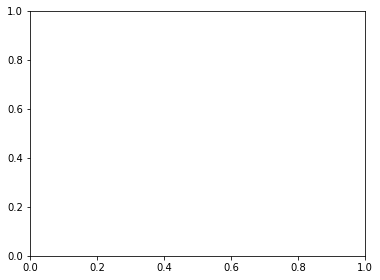

In [89]:
# y_pred =

fig, ax = plt.subplots(1,1,figsize=(6,4.5))
p1 = ax.plot(np.arange(1100,1300),y_pred["cv"][1100:1300],label='Predictions')
p2 = ax.plot(np.arange(1100,1300),y_true["cv"][1100:1300],label='True')
p3 = ax.plot(np.arange(1100,1300),np.squeeze(y_pis["cv"][1100:1300]),label='95 % CI',color='r')
custom_lines = [Line2D([0], [0], color=p1[0].get_color()),
                Line2D([0], [0], color=p2[0].get_color()),
                Line2D([0], [0], color=p3[0].get_color())]
ax.legend(custom_lines, ['Predictions', 'True', '95 % CI'])
ax.legend()
ax.set_xlabel('Sample')
ax.set_ylabel('LivLongSxD1 [mm]')
plt.savefig('plots/simple_model_linear.pdf',format='pdf')
plt.show()

In [90]:
random_forests = [None] * ytrain.shape[1]
rf_feature_importances = [None] * ytrain.shape[1]

In [91]:
y_predictions = [None] * ytrain.shape[1]

with parallel_backend('loky', n_jobs=-4):
    factor = 100
    n_trees = 5000
    for i,k in enumerate(range(12)):
        break
        s = time.time()
        print('Attribute', k)

        random_forest = ensemble.RandomForestRegressor(
                n_estimators=n_trees, 
                max_samples=factor/n_trees)
        random_forest.fit(Atrain, ytrain[:,k])

        # yhat_train_forest = random_forest.predict(Atrain)
        # yhat_val_forest = random_forest.predict(Aval)

        print('Time:', time.time() - s)
        rf_feature_importances[k] = random_forest.feature_importances_
        y_predictions[k] = random_forest.predict(Aval[:5000,:])
        s = time.time()

In [92]:
if rf_feature_importances[0] != None:
    random_forest_feature_importances = ((np.array(rf_feature_importances).T * rf_val[0]).sum(1)/rf_val[0].sum()).T
    y_pred = np.transpose(np.vstack(y_predictions))
    np.save("cache/random_forest_feature_importances.npy",random_forest_feature_importances)
    np.save("cache/y_pred_random_forest.npy", y_pred)
else:
    random_forest_feature_importances = np.load("cache/random_forest_feature_importances.npy")
    y_pred = np.load("cache/y_pred_random_forest.npy")

In [93]:
y_true = yval[0:5000,:]
print(y_pred.shape)

(5000, 12)


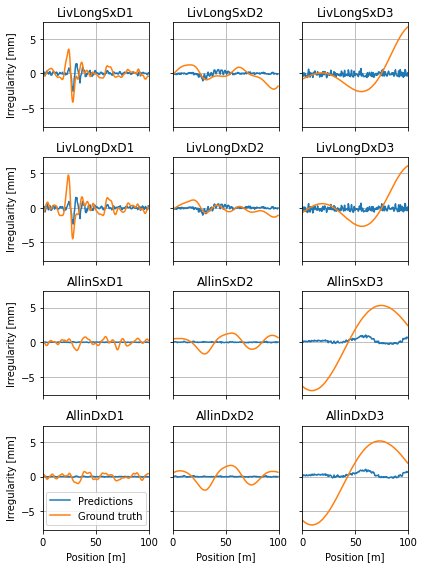

In [103]:
labels = ['LivLongSxD1', 'LivLongDxD1', 'AllinSxD1', 'AllinDxD1',
          'LivLongSxD2', 'LivLongDxD2', 'AllinSxD2', 'AllinDxD2',
          'LivLongSxD3', 'LivLongDxD3', 'AllinSxD3', 'AllinDxD3']
lower=2500
upper=2700
fig, axes = plt.subplots(4,3,figsize=(6,4/3*6), sharex=True, sharey=True)
axes = axes.T
for i, ax in enumerate(axes.flatten()):
    if i == 3:
        p1 = ax.plot(np.arange(0,200)/2,y_pred[lower:upper,i], label="Predictions")
        p2 = ax.plot(np.arange(0,200)/2,y_true[lower:upper,i], label="Ground truth")
        ax.legend(loc="lower center")
    else:
        p1 = ax.plot(np.arange(0,200)/2,y_pred[lower:upper,i])
        p2 = ax.plot(np.arange(0,200)/2,y_true[lower:upper,i])
    if i%4 == 3: ax.set_xlabel('Position [m]')
    if i < 4: ax.set_ylabel('Irregularity [mm]')
    ax.set_title(labels[i])
    ax.grid()
ax.set_xlim([0, 100])
fig.tight_layout()
plt.savefig('plots/simple_model_rf.pdf',format='pdf')
plt.show()

In [ ]:
from matplotlib import colors

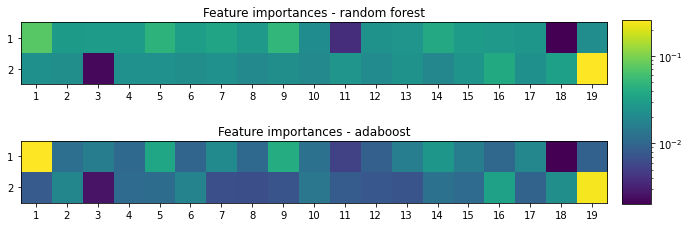

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10,4))

fi = random_forest_feature_importances.reshape(2,19)
ax = axes[0]
pos = ax.imshow(fi, norm=colors.LogNorm())
ax.set_xticks([i for i in range(19)])
ax.set_xticklabels([1+i for i in range(19)])
ax.set_yticks([i for i in range(2)])
ax.set_yticklabels([1+i for i in range(2)])
ax.set_title('Feature importances - random forest')

fi = adaboost_feature_importances.reshape(2,19)
ax = axes[1]
pos = ax.imshow(fi, norm=colors.LogNorm())
ax.set_xticks([i for i in range(19)])
ax.set_xticklabels([1+i for i in range(19)])
ax.set_yticks([i for i in range(2)])
ax.set_yticklabels([1+i for i in range(2)])
ax.set_title('Feature importances - adaboost')

# fig.colorbar(pos, ax=ax)
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.96, 0.185, 0.04, 0.64])
fig.colorbar(pos, cax=cbar_ax, orientation="vertical")

fig.savefig("plots/feature importance.pdf",format="pdf")

In [ ]:
labels_X = [
    "Velocità [km/h]", "AccB1Y [m/s^2]", "AccB1Z [m/s^2]", "AccCR1Y [m/s^2]", "AccCR1Z [m/s^2]", "AccB2Y [m/s^2]", "AccB2Z [m/s^2]", # 0-6
    "AccCR2Y [m/s^2]", "AccCR2Z [m/s^2]", "AccB3Y [m/s^2]", "AccB3Z [m/s^2]", "AccCR3Y [m/s^2]", "AccCR3Z [m/s^2]", "AccB4Y [m/s^2]", # 7-13
    "AccB4Z [m/s^2]", "AccCR4Y [m/s^2]", "AccCR4Z [m/s^2]", "AccB5Y [m/s^2]", "AccB5Z [m/s^2]", "AccCR5Y [m/s^2]", "AccCR5Z [m/s^2]", # 14-20
    "AccB6Y [m/s^2]", "AccB6Z [m/s^2]", "AccCR6Y [m/s^2]", "AccCR6Z [m/s^2]", "AccB7Y [m/s^2]", "AccB7Z [m/s^2]", "AccCR7Y [m/s^2]", # 21-27
    "AccCR7Z [m/s^2]", "AccB8Y [m/s^2]", "AccB8Z [m/s^2]", "AccCR8Y [m/s^2]", "AccCR8Z [m/s^2]", # 28-32
    "AccCSAY [m/s^2]", "AccCSAZ [m/s^2]", "AccCSBY [m/s^2]", "AccCSBZ [m/s^2]", # 33-36
    "Curvatura [1/m]" # 37
]

In [ ]:
[labels_X[i] for i in [0,10,17,21,37]]

['Velocità [km/h]',
 'AccB3Z [m/s^2]',
 'AccB5Y [m/s^2]',
 'AccB6Y [m/s^2]',
 'Curvatura [1/m]']

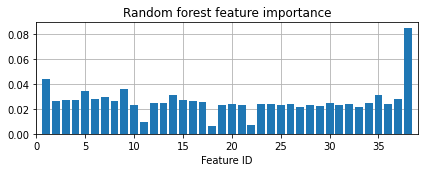

In [107]:
fig, ax = plt.subplots(1,1,figsize=(6,2.5))

ax.bar(np.arange(1,39), random_forest_feature_importances)
ax.set_xlabel("Feature ID")
ax.set_title("Random forest feature importance")
ax.set_xlim([0, 39])
ax.grid()

fig.tight_layout()

fig.savefig("plots/feature importance rf.pdf", format="pdf")
plt.show()

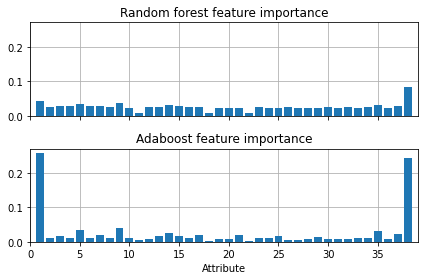

In [115]:
fig, axes = plt.subplots(2,1,figsize=(6,4),sharey=True, sharex=True)

ax = axes[0]
ax.bar(np.arange(1,39), random_forest_feature_importances)
ax.set_title("Random forest feature importance")
ax.set_xlim([0, 39])
ax.grid()

ax = axes[1]
ax.bar(np.arange(1,39), adaboost_feature_importances)
ax.set_xlabel("Attribute")
ax.set_title("Adaboost feature importance")
ax.set_xlim([0, 39])
ax.grid()

fig.tight_layout()

fig.savefig("plots/feature importance.pdf", format="pdf")
plt.show()